In [43]:
def Leapfrog(theta, r, grad, eps, L):
    """
    SUMMARY: 
    From Algorithm 1 in NUTS, Leapfrog step in Hamiltonian Monte Carlo/NUTS.
    Helper function for Algorithm 6. 
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    eps = step size
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
       
    OUTPUTS:
    theta_tilde = update theta vector
    
    r_tilde = updated r momenta vector
    """
    
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde, grad_tilde, logp_tilde

In [44]:
def FindReasonableEpsilon(theta, grad, logp, L):
    """
    SUMMARY:
    From Algorithm 4 in NUTS.
    Heuristic for choosing an initial value of epsilon.
    Helper function for Algorithm 6.
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    eps = value for initial value of epsilon, step size
    
    """
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L);
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [45]:
def BuildTree(theta, r, grad, u, v, j, eps, L, esto0):
    """
    SUMMARY:
    builds tree in NUTS sampler, helper function for Algorithm 6
    
    INPUTS:
    
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    v = direction in creating tree, value from -1 to 1
    
    j = height of tree, starts at 0
    
    eps = step size
    
    r_theta0 = joint probability of theta0 and r
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime
    
    """
    
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime, grad_prime, logp_prime = Leapfrog(theta, r, grad, v*eps, L)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)

        n_prime = int(u <= np.exp(esto))
        
        s_prime = int(esto > np.log(u) - 1000)

        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, grad_prime, theta_prime, r_prime, grad_prime, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, grad, u, v, j-1, eps, L, esto0)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, grad_minus, _,_,_, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, grad_minus, u, v, j-1, eps, L, esto0)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, grad_plus, u, v, j-1, eps, L, esto0)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
                grad_prime = grad_doub_prime
                logp_prime = logp_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [46]:
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    """
    SUMMARY: 
    Implemented from Algorithm 6: NUTS with Dual Averaging.
    Needs helper functions BuildTree, FindReasonableEpsilon, and Leapfrog.
    

    INPUTS:
    
    theta0 = initial values for values of parameters in model. len(theta0) = number of parameters
    
    M = number of samples desired
    
    M_adapt = the number of steps for the burn-in,
    also how long to run the dual averaging algorithm to find the appropriate epsilon
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    delta = target HMC acceptance probability.
    default value of 0.6
    is a value between 0 and 1
    
    
    OUTPUTS:
    
    samples = np.array matrix of samples of theta from algorithm
    dimensions of matrix are M x len(theta0)
    
    burned_in = same as samples matrix with burn_in samples removed
    dimensions of matrix are are M-M_adapt x len(theta0)
    
    """
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    logp, grad = L(theta0)
    eps = FindReasonableEpsilon(theta0, grad, logp, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0
        grad_minus = grad
        grad_plus = grad
        
        j = 0
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, grad_minus, _, _, _, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, grad_minus, u, v_j, j, eps, L, esto)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, grad_plus, u, v_j, j, eps, L, esto)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    logp = logp_prime
                    grad = grad_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
        
        eta = 1 / (m + t0)
        H_bar = (1 - eta)*H_bar + eta * (delta - alpha/n_alpha) 
        if m <= M_adapt:  
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eta = m**(-k)
            eps_bar = np.exp((1-eta) * np.log(eps_bar) + eta * np.log(eps))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    return samples, burned_in

In [38]:
# generate random poisson data
X_pois = np.random.poisson(5, 100)
def L_pois(theta):
    grad = sum(X_pois) / theta - 100
    logp = sum(X_pois)*np.log(theta) - theta*100
    return logp, grad
np.mean(X_pois)

4.7300000000000004

In [29]:
%%time
# run on poisson data
samples_pois, burned_in_pois = nuts6_dual_averaging(np.array([2]), 5000, 2000, L_pois)
np.mean(burned_in_pois)

5.1600574868954583

In [62]:
# multivariate normal data
cov = np.identity(10)
X_MVN = np.random.multivariate_normal(np.ones(10), cov, 100)

def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X_MVN:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

In [63]:
%%time
# run for MVN
samples_MVN, burned_in = nuts6_dual_averaging(np.zeros(10), 5000, 1000, L_MVN)


CPU times: user 39.7 s, sys: 238 ms, total: 40 s
Wall time: 40.2 s


In [64]:
# subset just accepted theta's
unique_samples = np.array(samples_MVN[0,:])
for i in range(1, M):
    if all(samples_MVN[i-1,:] != samples_MVN[i,:]):
        unique_samples = np.vstack([unique_samples, samples_MVN[i,:]])
 

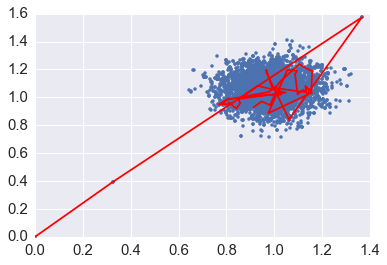

In [65]:
plt.plot(samples_MVN[:,0], samples_MVN[:,2], ".")
plt.plot(unique_samples[0:50,0], unique_samples[0:50,2], 'r')
pass

In [66]:
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [68]:
niter = 5000
with pm.Model() as test_context:
    mu = pm.MvNormal('mu', 0, tau=cov, shape= 10)
    y = pm.MvNormal('y', mu=mu, tau= cov, observed=X_MVN)
    step = pm.Metropolis()
    trace = pm.sample(niter,step=step)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [69]:
metropolis_samples = trace['mu']


In [70]:
unique_samples_met = np.array([metropolis_samples[0,:]])
# subset just accepted theta's
for i in range(1, niter):
    if all(metropolis_samples[i-1,:] != metropolis_samples[i,:]):
        unique_samples_met = np.vstack([unique_samples_met, metropolis_samples[i,:]])   

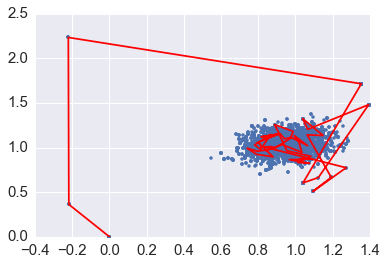

In [71]:
plt.plot(metropolis_samples[:,0], metropolis_samples[:,2], ".")
plt.plot(unique_samples_met[0:50,0], unique_samples_met[0:50,2], 'r')
pass

In [72]:
# test speed up ratio for 50-d
# 50 dimensional multivariate normal data
cov = np.identity(50)
X_MVN = np.random.multivariate_normal(np.ones(50), cov, 100)

def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X_MVN:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

In [73]:
%%time
samples_MVN, burned_in = nuts6_dual_averaging(np.zeros(50), 5000, 1000, L_MVN)

CPU times: user 3min 58s, sys: 2min 32s, total: 6min 31s
Wall time: 4min 47s
